# AlteredNet Classification for Detection of Real and AI-altered Imagery

In the following notebook, I will demonstrate how to perform the classification of AlteredNet images using assorted Neural Networks. It is highly recommended to use a CUDA-compatible system when running this notebook to save time on training.

## Environment Setup
### Import Requirements

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
from IPython.utils import io
from collections import OrderedDict

### Device Setup

Use parallel computing on GPU in CUDA-capable systems, otherwise - use CPU.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("using device:", device)

using device: cuda


## Load Data

### Local Dataset and Data Loader Functions

The `CustomImageDataset` function is used for fetching images from the [train, test, valid] directories, and storing them in a Dataset object, along with their labels from [train_labels.csv, test_labels.csv, valid_labels.csv,]

The `create_dataloader` function, on the other hand, is used for transforming the Dataset object, converting it into a Tensor datatype, and storing it as a batch-based Dataloader object, ready for training.

In [3]:
class CustomImageDataset(Dataset):
    """
    load local dataset to a structure recognized by dataloaders
    - input labels: Pandas DataFrame
    - input img_dir: string, the path to the samples directory
    - input transform (optional): a Torch transforms object

    - output image: a Pytorch Tensor of samples
    - output label: a list of labels
    """
    def __init__(self, labels, img_dir, transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):      
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def create_dataloader(data_dir, batch_size, labels, size=224):
    """
    transforms custom dataset and converts it into a pytorch dataloader object
    - input data_dir: string with the path to a data directory
    - input batch_size: an integer that represents the batch size
    - input labels: Pandas DataFrame that stores the data labels
    - input size (optional): sets the final pixel width and height of the samples

    - output dataloader: a pytorch dataloader object
    """
    if size == 224:
        # resize and crop AlteredNet samples
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
        ])
    elif size == 512:
        # no resizing and cropping required
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    else:
        print("sorry, only size 224 or 512 can be loaded, please try again")
        transform = None
    
    # load samples into a custom image dataset
    data = CustomImageDataset(labels, data_dir, transform=transform)

    # convert custom image dataset into a data loader
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader

### Generate Dataloaders

In [4]:
label_df = {i: pd.read_csv("data/labels/" + i + "_labels.csv") for i in ["train", "test", "valid"]}

dataloaders = {}

dataloaders["train"] = create_dataloader("data/train", 5, label_df["train"], size=224)
dataloaders["test"] = create_dataloader("data/test", 5, label_df["test"], size=224)
dataloaders["valid"] = create_dataloader("data/valid", 5, label_df["valid"], size=224)

### Plot DataLoader Batch Function

In [5]:
def plot_batch(dataloader):
    """
    display a randomly selected batch of data
    - dataloader: a pytorch dataloader object, of either the training, test or validation data
    """
    # fetch random batch
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    batch_size = dataloader.batch_size
    # set up 4 s column figure
    fig = plt.figure(figsize = (9, 9))
    columns, rows = batch_size, 1
    counter = 1
    # plot batch images
    for (i, l) in zip(images, labels):
        fig.add_subplot(rows, columns, counter)
        # transform sample
        img = i.squeeze()
        img = img.permute(1, 2, 0)
        # dispaly image on figure
        with io.capture_output() as captured:
            plt.imshow(img)
        # plot settings
        plt.axis('off')
        plt.subplots_adjust(wspace = 0, hspace = 0)
        plt.title(("real" if int(l) == 1 else "fake"))
        # increaase counter for next iteration
        counter += 1
    # display figure
    plt.show()

### Plot and Sample One Batch

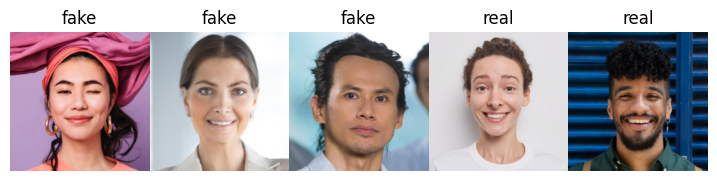

batch size 5
-----------------------------------------
batch shape: torch.Size([5, 3, 224, 224])
sample shape: torch.Size([3, 224, 224])
labels shape: torch.Size([5])
-----------------------------------------
tensor([0, 1, 1, 1, 0])
-----------------------------------------
sample 0 value range: tensor(0.) tensor(0.9765)


In [6]:
plot_batch(dataloaders["train"])

for batch, label in dataloaders["train"]:
    print("batch size", batch.shape[0])
    print("-----------------------------------------")
    print("batch shape:", batch.shape)
    print("sample shape:", batch[0].shape)
    print("labels shape:", label.shape)
    print("-----------------------------------------")
    print(label)
    print("-----------------------------------------")
    print("sample 0 value range:", batch[0].min(), batch[0].max())
    break

## Sample Models - Hyper Parameterization

In this section, I will load two pre-trained state-of-the-art neural networks and adapt them to the following settings:

- `2` output units representing two classes [fake, real], rather than `1000` of them
- `1` fully connected layer instead of `2` to simplify the neural netowrk, given the small number of dataset samples.

Then, I will find the best model architecture for each using different dropout rates and different numbers of hidden units.

### Load Model Function

The following function will load and adapt the VGG-19 and AlexNet models.

In [7]:
def load_model(kind, io_units, dropout): 
    """
    load AlexNet or VGG pre-trained neural networks
    and customize for binary classification

    - input(optional): string, either "alexnet" or "vgg"
    - output: class torchvision.models
    """

    if kind.lower() == "vgg":
        # load VGG
        model = models.vgg19(weights='DEFAULT')
        input_units = model.classifier[0].in_features
        
    elif kind.lower() =="alexnet":
        # load AlexNet
        model = models.alexnet(weights='DEFAULT')
        input_units = model.classifier[1].in_features
    
    # freeze parameters for backpropagation
    for param in model.parameters():
        param.requires_grad = False
        
    # re-build classifier, keep only one fully connected layer
    classifier = nn.Sequential(OrderedDict([
                    ("0", nn.Linear(in_features=input_units, out_features=io_units, bias=True)),
                    ("1", nn.ReLU(inplace=True)),
                    ("2", nn.Dropout(p=dropout, inplace=False)),
                    # output layer, returning one of two classes
                    ("3", nn.Linear(io_units, 2)), 
                    # activation function, called on output
                    ('4', nn.LogSoftmax(dim=1)) 
                    ]))
    # update classifier    
    model.classifier = classifier
    return model

### Find Optimal Classifier Architecture

#### Model Sampling Function

In [8]:
def sample_models(model_kind, io_units, dropout_rates):
    """
    create model variations with different hidden units and dropout
    
    - input model_kind: 
        string, eitehr "vgg" or "alexnet"
    - input io_units: 
        list of integers, representing hidden units to sample
    - input dropout_rate: 
        list of floats, representing dropout rates to sample

    - output models: 
        list of dictionaries, storing models and their parameters
    """
    models = []
    counter = 0
    for io in io_units:
        for d in dropout_rates:
            models.append({
                "id": counter,
                "io_units": io,
                "dropout": d,
                "model": load_model(kind=model_kind, io_units=io, dropout=d),
            })
            counter += 1
    return models

#### Sample Models

a list of models to sample will be stored in the following variables:

In [81]:
vgg_models = sample_models("vgg", [512, 448, 372], [0.8, 0.6])
alexnet_models = sample_models("alexnet", [256, 172, 128], [0.2, 0.5])

## Train and Validate Sampling Models

### Validation Function

In [10]:
#Validation Function
def validation(model, testloader, criterion):
    """
    valitation function for in-training evaluation
    """
    #Define validation variables
    validation_loss = 0
    validation_accuracy = 0
    #Itterare over the validation set
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        validation_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        validation_accuracy += equality.type(torch.FloatTensor).mean()  
        
    return validation_loss, validation_accuracy

### Save and Load Checkpoint Functions

In [11]:
def save_checkpoint(model, model_name, optimizer):
    """
    save fine-tunned model to system
    - input model: trained torchvision model object
    - input model_name: string of either "VGG" or "AlexNet"
    - input: pytorch optimizer object, based on the model input
    """
    checkpoint = {
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(checkpoint, "data/checkpoints/" + model_name + "_checkpoint.pth")
             
def load_checkpoint(path):
    """
    load model checkpoint from system
    - input path: string that represents the path to the .pth checkpoint file 
    - output model: torchvision model object of the loaded checkpoint
    """
    checkpoint = torch.load(path)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    model.optimizer_state = checkpoint['optimizer_state']
    return model

### Train Function

In [12]:
def train(model, model_id, epochs, trainloader, validloader, criterion, weight_decay, is_save=False):
    """
    train model on training and validation subsets
    - input model: torchvision model object
    - input model_id: integer represents a sequential unique model identification number
    - input epochs: integer that represents the number of training epochs
    - input trainloader: dataloader object with training data
    - input validloader: dataloader object with validation data
    - criterion: loss object
    - weight_decal: float that represents the rate of weight decay regularization
    - is save: boolean represent of wether to save the trained checkpoint locally or not
    """
    # send model to device
    model.to(device)

    val_loss = []
    val_accuracy = []
    train_loss = []
    train_acc = []

    # 3e-4
    optimizer = optim.Adam(
        model.classifier.parameters(), 
        lr = learning_rate, 
        weight_decay = weight_decay
    )
    steps = 0

    for e in range(epochs):
        model.train()
        running_loss = 0
        train_accuracy = []
        
        #Itterare over the training set
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)        
            optimizer.zero_grad() 
            outputs = model.forward(inputs)
            ps = torch.exp(outputs)
            equality = (labels.data == ps.max(dim=1)[1])
            batch_acc = equality.type(torch.FloatTensor).mean()
            train_accuracy.append(batch_acc)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            #Model Progress
            if steps % print_every == 0:
                #Model in evaluation
                model.eval()    
                with torch.no_grad():
                    validation_loss, validation_accuracy = validation(model, validloader, criterion)

                print("epoch: {}/{} | train loss: {:.2f} | val loss: {:.2f} | train acc: {:.2f} | val acc: {:.2f} | ".format(
                    e+1,
                    epochs,
                    running_loss/print_every,
                    validation_loss/len(validloader),
                    sum(train_accuracy)/len(train_accuracy),
                    validation_accuracy/len(validloader)
                ))
                
                val_loss.append(validation_loss/len(validloader))
                train_loss.append(running_loss/print_every)  
                val_accuracy.append(validation_accuracy/len(validloader))
                train_acc.append(sum(train_accuracy)/len(train_accuracy))
                
                running_loss = 0

            # Model back to training
            model.train()
    # save checkpoint if flagged        
    if is_save == True:
        model_name = (str(type(model)).split(".")[-1]).split("'")[0] + "_" + str(model_id)
        save_checkpoint(model, model_name, optimizer)
    
    print("*************************************************")
    print("model", model_id, "is done, moving to next model..." )
    print("*************************************************")
    return val_loss, val_accuracy, train_loss, train_acc
    

### Get Sampling Results

#### Sampling Results Function

In [13]:
def get_sampling(sample_models, epochs, weight_decay):
    """
    train a dictionary of models with different hyperparameters
    - input sample_models: list of dictionaries containing models and their attributes
    - input epochs: integer that represents the number of training epochs
    - input weight_decay: float that represents the degree of weight decay regularization
    
    - output results: a list of training outputs, each represents a different model
    """
    results = []
    for i in range(len(sample_models)):
        res = train(sample_models[i]["model"], i, epochs, dataloaders['train'], dataloaders['valid'], criterion, weight_decay)
        results.append(res)
    return results

#### Sampling Results for VGG 

In [19]:
learning_rate = 0.0003
weight_decay = 3e-4
epochs = 12
criterion = nn.NLLLoss(reduction="sum")
print_every = 50

vgg_results = get_sampling(vgg_models, epochs, weight_decay)

epoch: 1/12 | train loss: 3.61 | val loss: 3.56 | train acc: 0.44 | val acc: 0.40 | 
epoch: 2/12 | train loss: 3.99 | val loss: 3.56 | train acc: 0.41 | val acc: 0.45 | 
epoch: 3/12 | train loss: 3.54 | val loss: 3.54 | train acc: 0.46 | val acc: 0.48 | 
epoch: 4/12 | train loss: 3.23 | val loss: 3.47 | train acc: 0.51 | val acc: 0.48 | 
epoch: 5/12 | train loss: 3.26 | val loss: 3.54 | train acc: 0.52 | val acc: 0.52 | 
epoch: 6/12 | train loss: 2.98 | val loss: 3.47 | train acc: 0.47 | val acc: 0.45 | 
epoch: 7/12 | train loss: 2.75 | val loss: 3.52 | train acc: 0.51 | val acc: 0.55 | 
epoch: 8/12 | train loss: 2.59 | val loss: 3.61 | train acc: 0.55 | val acc: 0.48 | 
epoch: 9/12 | train loss: 2.48 | val loss: 3.57 | train acc: 0.49 | val acc: 0.47 | 
epoch: 10/12 | train loss: 2.26 | val loss: 3.58 | train acc: 0.53 | val acc: 0.48 | 
epoch: 11/12 | train loss: 2.17 | val loss: 3.54 | train acc: 0.53 | val acc: 0.50 | 
epoch: 12/12 | train loss: 1.94 | val loss: 3.55 | train acc: 0

#### Sampling Results for AlexNet

In [82]:
learning_rate = 0.0001
weight_decay = 0.005
alexnet_results = get_sampling(alexnet_models, epochs, weight_decay)

epoch: 1/12 | train loss: 4.31 | val loss: 3.83 | train acc: 0.42 | val acc: 0.50 | 
epoch: 2/12 | train loss: 3.78 | val loss: 3.58 | train acc: 0.50 | val acc: 0.50 | 
epoch: 3/12 | train loss: 3.25 | val loss: 3.51 | train acc: 0.53 | val acc: 0.47 | 
epoch: 4/12 | train loss: 3.12 | val loss: 3.56 | train acc: 0.50 | val acc: 0.50 | 
epoch: 5/12 | train loss: 2.97 | val loss: 3.51 | train acc: 0.48 | val acc: 0.47 | 
epoch: 6/12 | train loss: 2.82 | val loss: 3.51 | train acc: 0.52 | val acc: 0.43 | 
epoch: 7/12 | train loss: 2.59 | val loss: 3.50 | train acc: 0.57 | val acc: 0.48 | 
epoch: 8/12 | train loss: 2.45 | val loss: 3.50 | train acc: 0.52 | val acc: 0.45 | 
epoch: 9/12 | train loss: 2.36 | val loss: 3.50 | train acc: 0.54 | val acc: 0.48 | 
epoch: 10/12 | train loss: 2.20 | val loss: 3.54 | train acc: 0.53 | val acc: 0.50 | 
epoch: 11/12 | train loss: 2.02 | val loss: 3.50 | train acc: 0.54 | val acc: 0.47 | 
epoch: 12/12 | train loss: 1.82 | val loss: 3.51 | train acc: 0

### Visualize Sampling Reasults
#### Plot Sampling Reasults Function

In [20]:
def plot_training_results(results, my_models, model_name, metric):
    """
    plot desired evaluation metric for 6 or 3 models - accuracy or loss
    - input results: dictionary of 4 training metrics:
            - validation loss
            - training loss
            - validation accuracy
            - training accuracy
    - input my_models: dictionaty of torchvision models
    - input model name: string of either "VGG" or "AlexNet" depending on the designation of the reuslts dict
    - input metric: string of wither "accuracy" or "loss", depending on the desired metric to plot
    """
    if len(results) == 3:
        # plot one row of 3 graphs
        rows, cols = 1, len(results)
        fig, ax1 = plt.subplots(rows, cols, figsize=(10, 4))
    else:   
        # plot two rows of len(results)/2
        rows, cols = 2, int(len(results)/2)
        fig, (ax1, ax2) = plt.subplots(rows, cols, figsize=(10, 4), sharex=True, sharey=True)

    for i in range(len(results)):
        # fetch model information
        model_info = "| {} | units: {} | dropout: {} |".format(
                my_models[i]["id"], my_models[i]["io_units"], my_models[i]["dropout"])
        
        # unpack training results
        unpacked_results = {}
        unpacked_results["valid_loss"], unpacked_results["valid_acc"], unpacked_results["train_loss"], unpacked_results["train_acc"] = results[i]
      
        if metric == "accuracy":
            # fetch accuracy data
            acc = {'valid': unpacked_results["valid_acc"], 'train': unpacked_results["train_acc"]}
            data = pd.DataFrame(data=acc)      
        elif metric == "loss":   
            # fetch loss data
            loss = {'valid': unpacked_results["valid_loss"], 'train': unpacked_results["train_loss"]}
            data = pd.DataFrame(data=loss)
        else:
            print("unrecognized metric, please choose 'accuracy' or 'loss'...")

        # plot first row
        if i < cols:            
            if len(results) == 3 and metric == "accuracy":
                # plot 1 row of accuracy data
                ax1[i].plot(acc["valid"], label="valid")
                ax1[i].plot(acc["train"], label="train")
                
            elif len(results) == 3 and metric == "loss":
                # plot 1 row of loss data
                ax1[i].plot(loss["valid"], label="valid")
                ax1[i].plot(loss["train"], label="train")
            else:
                # plot first row of loss or accuracy data
                ax1[i].plot(data, label=data.columns)
            # plot parameters
            ax1[i].legend(loc="upper right")
            ax1[i].title.set_text(model_info)              
            ax1[i].set_ylabel(metric)
            ax1[i].set_xlabel("epoch")
            
        elif i + 1 >= cols and len(results) != 3:
            # plot second row of loss or accuracy data
            idx = abs(len(results)//2 - i)
            ax2[idx].plot(data, label=data.columns)
            ax2[idx].legend(loc="upper right")
            ax2[idx].title.set_text(model_info)
            ax2[idx].set_ylabel(metric)
            ax2[idx].set_xlabel("epoch")
            
    fig.suptitle(model_name + ' train and valid '+ metric +' over epochs, lr=' + str(learning_rate))
    plt.subplots_adjust(top=0.85)
    plt.subplots_adjust(left=0.01)
    plt.subplots_adjust(bottom=0.05)

    for ax in fig.get_axes():
        ax.label_outer()
    
    plt.show()

#### Plot VGG Accuracy and Loss Results

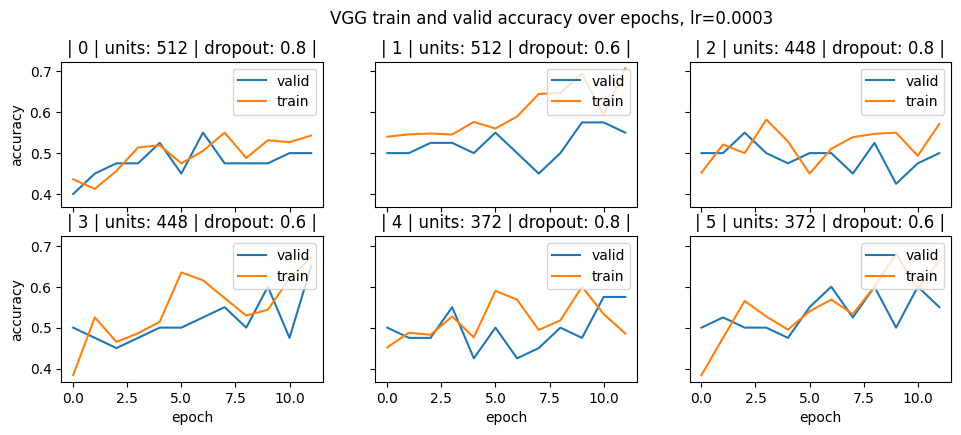

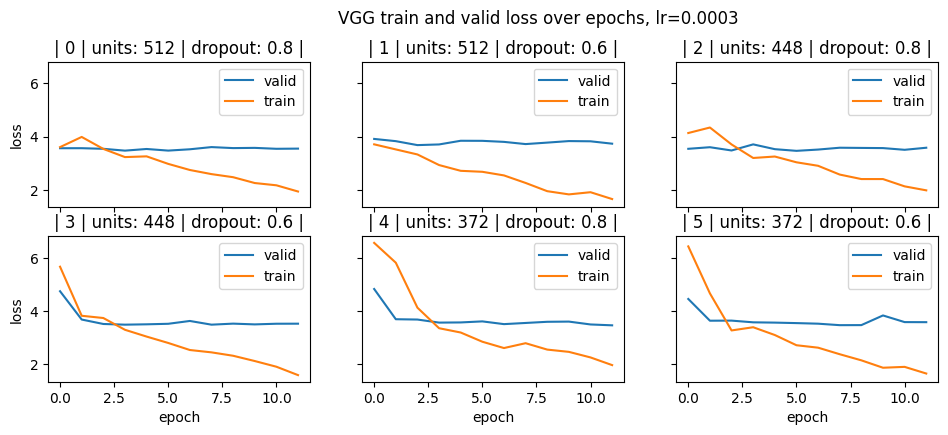

In [21]:
plot_training_results(vgg_results, vgg_models, "VGG", "accuracy")
plot_training_results(vgg_results, vgg_models, "VGG", "loss")

#### Plot AlexNet Accuracy and Loss Results

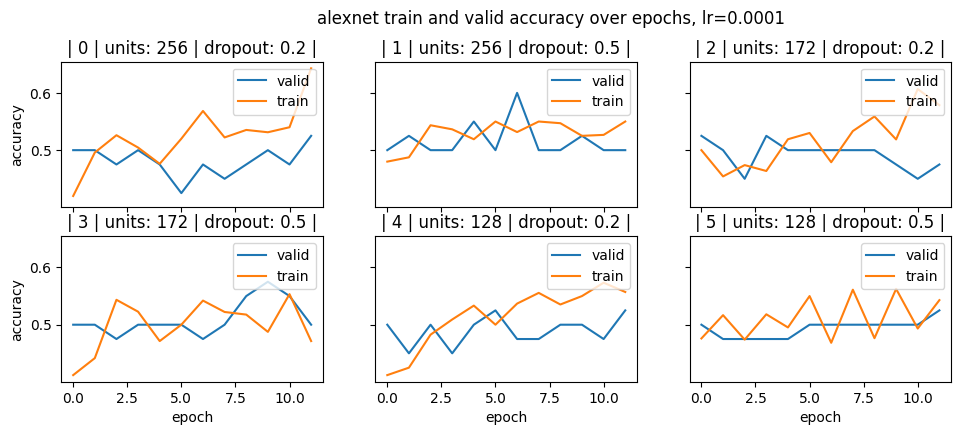

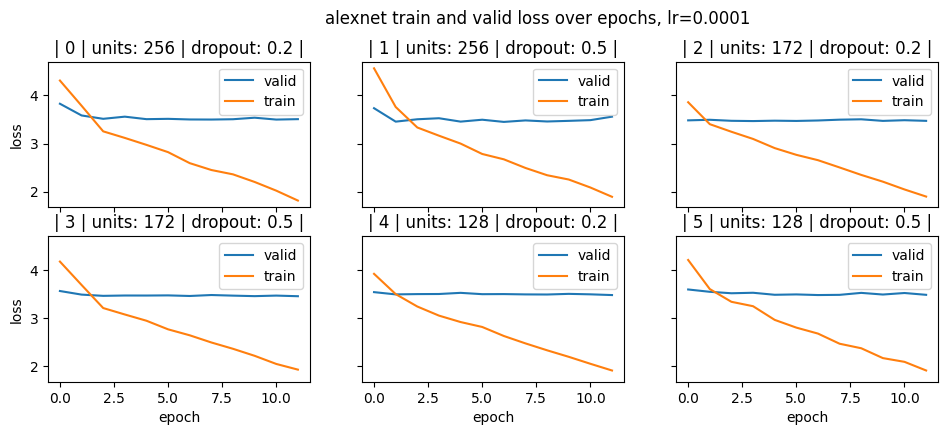

In [83]:
plot_training_results(alexnet_results, alexnet_models, "alexnet", "accuracy")
plot_training_results(alexnet_results, alexnet_models, "alexnet", "loss")

#### Manually Select The Best Performing Models

In [84]:
best_vgg = vgg_models[3]
best_alexnet = alexnet_models[0]

print("selected VGG-16 model with id: {}, hidden units: {}, and dropout: {}".format(
    best_vgg["id"], 
    best_vgg["io_units"], 
    best_vgg["dropout"], 
))

print("selected AlexNet model with id: {}, hidden units: {}, and dropout: {}".format(
    best_alexnet["id"],
    best_alexnet["io_units"],
    best_alexnet["dropout"], 
))

selected VGG-16 model with id: 3, hidden units: 448, and dropout: 0.6
selected AlexNet model with id: 0, hidden units: 256, and dropout: 0.2


## Sample Epochs

In this section, I will explore the optimal number of epochs for each of the two selected models. The following evauation is performed on the test set and yields additional metrics: precision and recall.

### Evaluation Function
a function that evaluates a model on never before seen images from the test set

In [105]:
def test(model, testloader):
    """
    evaluate model on the test set
    - input model: torchvision model object
    - input test loader: pytorch dataloader object, containing the test set
    """
    #Validation on the test set
    correct = 0
    total = 0
    n_test = len(testloader.dataset)

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    #Itterare over the test set
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            model = model.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            TP += ((predicted==1) & (labels==1)).sum().item()
            TN += ((predicted==0) & (labels==0)).sum().item()
            FP += ((predicted==1) & (labels==0)).sum().item()
            FN += ((predicted==0) & (labels==1)).sum().item()

        print('Accuracy on {} test images: {} %'.format(n_test, (100 * correct / total)))
        print("---------------------------------------------------")
        print("true positives: {}, true negatives: {}".format(TP, TN))
        print("false positives: {}, false negatives: {}".format(FP, FN))
        print("---------------------------------------------------")
        print("recall: {:.2f}".format(TP / (TP + FN)))
        print("precision: {:.2f}".format(TP / (TP + FP)))
    return correct / total

### Epoch Sampling Train and Test Functions

- `train_sample_epochs` facilitates training the same model across a different number of epochs.
- `test_sample_epochs` evaluates the accuracy results of each epoch veriation

In [ ]:
def train_sample_epochs(model_dict, model_kind, sampling_epochs):   
    """
    train the same model over different number of epochs and return the results
    - input model_dict: a dictionary of torchivision models and their parameters.
    - input model_kind: a string of wither "VGG" or "AlexNet".
    - input sampling_epochs: a list of integers, representing the varying epoch numbers
    - output result: a list of floats, representing accuracy scores
    """
    results = []
    for i in sampling_epochs:
        # reset the model to eliminate previous training
        model = load_model(
            kind=model_kind, 
            io_units=model_dict["io_units"], 
            dropout=model_dict["dropout"]
        )
        
        res = train(model, str(i), i, dataloaders['train'], dataloaders['valid'], criterion, weight_decay, is_save=True)
        results.append(res)
    
    return results

def test_sample_epochs(model_kind, sampling_epochs):
    checkpoints = {
    v: load_checkpoint("data/checkpoints/" + model_kind + "_" + str(v) + "_checkpoint.pth") for v in sampling_epochs
    }
    result = []
    for i in sampling_epochs:
        print("----------------------------------------------")
        print("{} with {} epochs".format(model_kind, i))
        res = test(checkpoints[i], dataloaders['test'])
        result.append(res)
    return result
        

### Evaluate VGG Over Epochs

#### Train VGG Model for Varying Epochs

In [205]:
import warnings
warnings.filterwarnings('ignore')

# choose number of epochs to sample
sampling_epochs = [10, 24, 36]
print_every = 10

vgg_train_results = train_sample_epochs(best_vgg, "VGG", sampling_epochs)

epoch: 1/10 | train loss: 3.68 | val loss: 3.67 | train acc: 0.56 | val acc: 0.52 | 
epoch: 1/10 | train loss: 5.33 | val loss: 3.68 | train acc: 0.47 | val acc: 0.52 | 
epoch: 1/10 | train loss: 4.31 | val loss: 3.73 | train acc: 0.45 | val acc: 0.50 | 
epoch: 1/10 | train loss: 4.70 | val loss: 3.94 | train acc: 0.44 | val acc: 0.48 | 
epoch: 1/10 | train loss: 4.97 | val loss: 3.69 | train acc: 0.44 | val acc: 0.52 | 
epoch: 2/10 | train loss: 3.16 | val loss: 3.52 | train acc: 0.43 | val acc: 0.50 | 
epoch: 2/10 | train loss: 3.59 | val loss: 3.58 | train acc: 0.46 | val acc: 0.53 | 
epoch: 2/10 | train loss: 3.97 | val loss: 3.64 | train acc: 0.47 | val acc: 0.50 | 
epoch: 2/10 | train loss: 4.36 | val loss: 3.56 | train acc: 0.45 | val acc: 0.58 | 
epoch: 2/10 | train loss: 4.47 | val loss: 3.53 | train acc: 0.43 | val acc: 0.53 | 
epoch: 3/10 | train loss: 2.35 | val loss: 3.45 | train acc: 0.47 | val acc: 0.48 | 
epoch: 3/10 | train loss: 3.65 | val loss: 3.67 | train acc: 0.49

#### VGG Accuracy Results

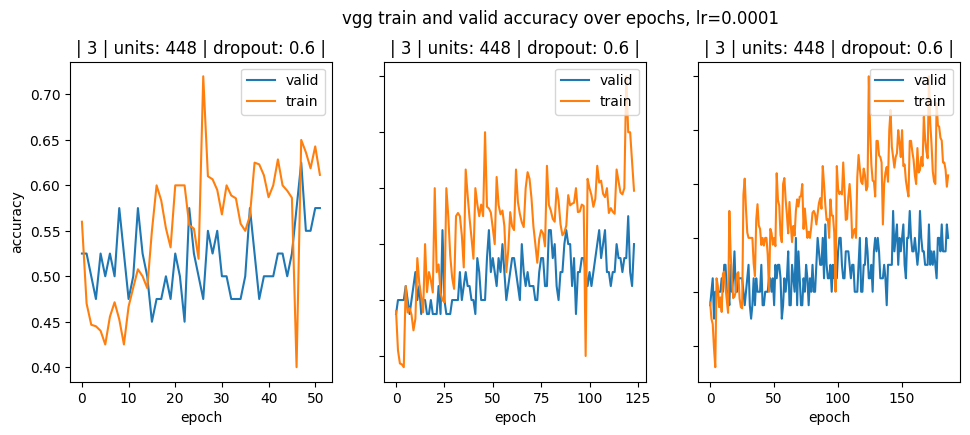

In [247]:
plot_training_results(vgg_train_results, [best_vgg, best_vgg, best_vgg], "vgg", "accuracy")

#### VGG Loss Results

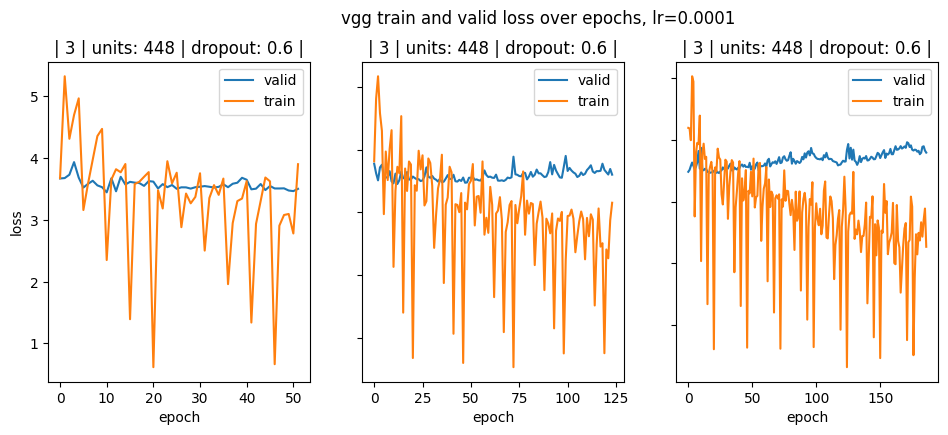

In [248]:
plot_training_results(vgg_train_results, [best_vgg, best_vgg, best_vgg], "vgg", "loss")

#### Evaluate Trained VGG Models on Test Data

In [233]:
vgg_test_results = test_sample_epochs("VGG", sampling_epochs)

----------------------------------------------
VGG with 10 epochs
Accuracy on 30 test images: 70.0 %
---------------------------------------------------
true positives: 10, true negatives: 11
false positives: 4, false negatives: 5
---------------------------------------------------
recall: 0.67
precision: 0.71
----------------------------------------------
VGG with 24 epochs
Accuracy on 30 test images: 63.333333333333336 %
---------------------------------------------------
true positives: 13, true negatives: 6
false positives: 9, false negatives: 2
---------------------------------------------------
recall: 0.87
precision: 0.59
----------------------------------------------
VGG with 36 epochs
Accuracy on 30 test images: 80.0 %
---------------------------------------------------
true positives: 12, true negatives: 12
false positives: 3, false negatives: 3
---------------------------------------------------
recall: 0.80
precision: 0.80


### Evaluate AlexNet Over Epochs

#### Train AlexNet Model for Varying Epochs

In [140]:
sampling_epochs = [10, 24, 36]

alexnet_train_results = train_sample_epochs(best_alexnet, "AlexNet", sampling_epochs)

epoch: 1/10 | train loss: 4.10 | val loss: 4.84 | train acc: 0.42 | val acc: 0.50 | 
epoch: 1/10 | train loss: 5.83 | val loss: 3.96 | train acc: 0.41 | val acc: 0.50 | 
epoch: 1/10 | train loss: 4.71 | val loss: 3.57 | train acc: 0.41 | val acc: 0.50 | 
epoch: 1/10 | train loss: 4.00 | val loss: 3.61 | train acc: 0.40 | val acc: 0.50 | 
epoch: 1/10 | train loss: 4.40 | val loss: 3.48 | train acc: 0.36 | val acc: 0.53 | 
epoch: 2/10 | train loss: 2.74 | val loss: 3.46 | train acc: 0.52 | val acc: 0.53 | 
epoch: 2/10 | train loss: 3.51 | val loss: 3.45 | train acc: 0.51 | val acc: 0.53 | 
epoch: 2/10 | train loss: 3.46 | val loss: 3.49 | train acc: 0.53 | val acc: 0.50 | 
epoch: 2/10 | train loss: 4.19 | val loss: 3.82 | train acc: 0.48 | val acc: 0.50 | 
epoch: 2/10 | train loss: 4.04 | val loss: 3.44 | train acc: 0.46 | val acc: 0.50 | 
epoch: 3/10 | train loss: 2.10 | val loss: 3.47 | train acc: 0.57 | val acc: 0.58 | 
epoch: 3/10 | train loss: 3.52 | val loss: 3.48 | train acc: 0.54

#### Plot AlexNet Training Results  for Different Epochs

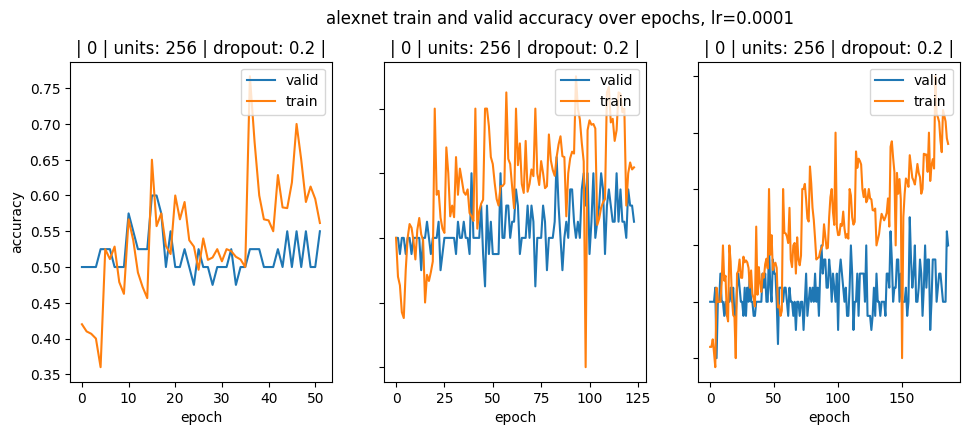

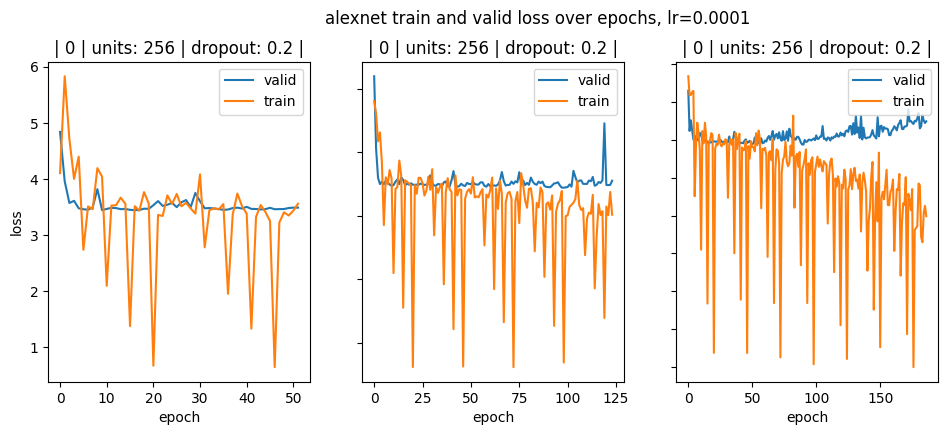

In [200]:
plot_training_results(alexnet_train_results, [best_alexnet, best_alexnet, best_alexnet], "alexnet", "accuracy")
plot_training_results(alexnet_train_results, [best_alexnet, best_alexnet, best_alexnet], "alexnet", "loss")

#### Evaluate Trained AlexNet Models on Test Data

In [198]:
alexnet_test_results = test_sample_epochs("AlexNet", sampling_epochs)

----------------------------------------------
AlexNet with 10 epochs
Accuracy on 30 test images: 70.0 %
---------------------------------------------------
true positives: 12, true negatives: 9
false positives: 6, false negatives: 3
---------------------------------------------------
recall: 0.80
precision: 0.67
----------------------------------------------
AlexNet with 24 epochs
Accuracy on 30 test images: 36.666666666666664 %
---------------------------------------------------
true positives: 10, true negatives: 1
false positives: 14, false negatives: 5
---------------------------------------------------
recall: 0.67
precision: 0.42
----------------------------------------------
AlexNet with 36 epochs
Accuracy on 30 test images: 46.666666666666664 %
---------------------------------------------------
true positives: 9, true negatives: 5
false positives: 10, false negatives: 6
---------------------------------------------------
recall: 0.60
precision: 0.47


## Predict One Image

In the following section, I will define a prediction function that evaluates only one image at a time (more suitable for production, rather than research)

### Prediction Functions

In [280]:
#Prediction Function
def predict(image, model, topk=1): 
    """
    returns the top k probabilities & classes for given image
    - input image: PILLOW image
    - input model: torchvision model object
    - input topk (optional): an integer that represents the number of top class probabilities to fetch
    
    - output topk_ps: a list in the length of topk, with float class probabilities
    - output topk_cs: a list in the length of topk, with integer class numbers
    """
    # convert sample into a numpy array and transpose its dimentions
    image_tensor = torch.from_numpy(image)
    image_tensor = np.transpose(image_tensor, (2,0,1))
    image_tensor.unsqueeze_(0)
    # load sample into device
    image_tensor = image_tensor.to(device)
    # turn off gradients for prediction
    with torch.no_grad():
        output = model.double().forward(image_tensor)
    # receive probabilities as 0 - 1 floats with exp
    ps = torch.exp(output)
    topk_combined = ps.topk(top_k, sorted=True)
    # fetch top k probabilities
    topk_ps = topk_combined[0][0]
    # fetch top k classes
    topk_cs = topk_combined[1][0]
    
    return topk_ps, topk_cs  

def process_image(image):
    """
    transforms a PILLOW image for a forward pass
    - input image: a PIL image object
    - output np_image: resized and normalized version of the image
    """
    if image.size[0] == image.size[1]:
        # if the image is quare
        image = image.resize((224,224))
    else:
        # if the image is landscape or portrait
        image = image.resize((256, image.size[1]//(image.size[0]/256)))
        image = image.crop((0,0,224,224))
    np_image = np.array(image)
    # normalize image pixels to values between 0 and 1
    np_image = np_image / 255
    return np_image

def compare_predictions(image_path, label, model1, model2, topk=1):
    """
    compares between predictions of two models on a sigle sample
    - input image_path: a string of the path to an image file
    - input label: integer representing tha label, either 0 or 1
    - input model1: torchvision model
    - input model2: torchvision model
    - input topk (optional): an integer that represents the number of top class probabilities to fetch
    """  
    #Define PIL image & run it with process_image() to get predictions
    image = Image.open(image_path)
    processed_img = process_image(image)    
    
    #Predicting top kk with predict()
    for m in [model1, model2]:
        topk_ps, topk_cs = predict(processed_img, m)
        name = (str(type(m)).split(".")[-1]).split("'")[0]
        val = 'fake' if int(topk_cs) == 0 else 'real'
        print("{} predicts the image is {} with {:.2f}% confidence".format(name, val, float(topk_ps)))
        print("----------------------------------------------------")
    
    print("actual label:", "fake" if int(label) == 0 else "real")
    
    plt.imshow(image)

### Predict with Best Versions of VGG and AlexNet
#### Predict Test Sample 10

VGG predicts the image is real with 0.97% confidence
----------------------------------------------------
AlexNet predicts the image is real with 0.54% confidence
----------------------------------------------------
actual label: real


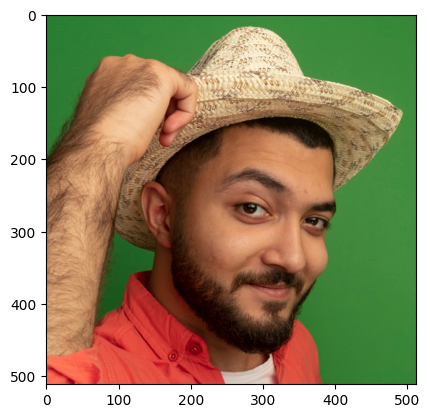

In [281]:
import numpy as np
from PIL import Image

vgg_model = load_checkpoint('data/checkpoints/VGG_24_checkpoint.pth')
alexnet_model = load_checkpoint('data/checkpoints/AlexNet_10_checkpoint.pth')

compare_predictions("data/test/10_test_real.png", 1, vgg_model, alexnet_model, topk=1)

#### Predict Test Sample 26

VGG predicts the image is fake with 0.55% confidence
----------------------------------------------------
AlexNet predicts the image is fake with 0.52% confidence
----------------------------------------------------
actual label: fake


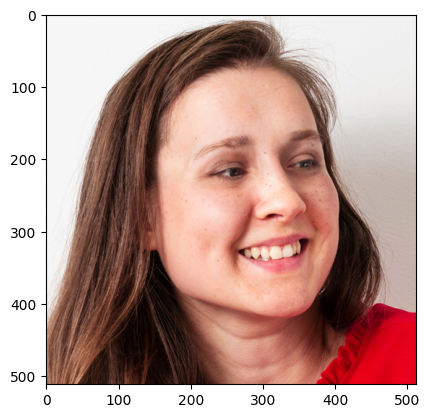

In [292]:
compare_predictions("data/test/26_test_fake.png", 0, vgg_model, alexnet_model, topk=1)

#### Predict Test Sample 5

VGG predicts the image is fake with 0.51% confidence
----------------------------------------------------
AlexNet predicts the image is real with 0.50% confidence
----------------------------------------------------
actual label: fake


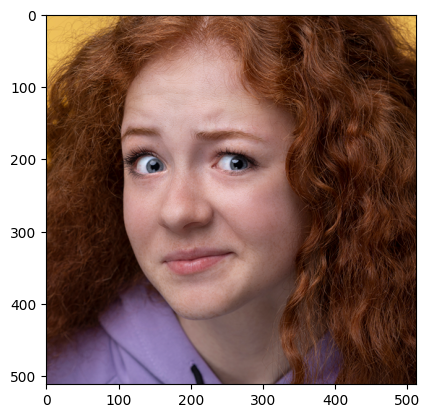

In [302]:
compare_predictions("data/test/5_test_fake.png", 0, vgg_model, alexnet_model, topk=1)